#### augmentation for the Unet structure

In [3]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']
# gpu_device_name = tf.test.gpu_device_name()
# print(gpu_device_name)

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15898260276
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 15185342964033605916
physical_device_desc: "device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:8a:00.0, compute capability: 6.0"



[None]

In [4]:
# data loading 

import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import os
import pandas as pd
import random

In [5]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

DATA_PATH = './synthetic/'  # in hemera, only use relative path
data_ids = next(os.walk(DATA_PATH))[1]
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|          | 0/3 [00:00<?, ?it/s]/home/li52/.local/lib/python3.6/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
 67%|██████▋   | 2/3 [00:00<00:00,  9.03it/s]

tomo2_focalseries.mrc
tomo3_focalseries.mrc
tomo1_focalseries.mrc
tomo2_groundtruth.mrc
tomo3_groundtruth.mrc


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

tomo1_groundtruth.mrc


In [6]:
# raw data sorting: padding, reshape

import torchio as tio
from patchify import patchify, unpatchify

# training dataset raw
train_raw = np.vstack(([focal[0], focal[1]]));train = train_raw[...,np.newaxis].transpose((3,1,2,0)); label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]

trainIO = tio.ScalarImage(tensor=train)
target_shape = 256,256,512  # padding into the same size
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

# testing dataset raw
X_test = focal[2]; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test_label = GT[2]; Y_test_label = (Y_test_label > 0.5).astype(np.float) 

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];

(512, 256, 256)
(512, 256, 256)


In [7]:
# patchify the images

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1

                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [8]:
# train dataset
patchPara = {'x': 256, 'y': 256, 'step':256}
Xtrain_patches, _ = rawPatch(train_padd, patchPara);Xtrain_patches = np.stack((Xtrain_patches,)*3, axis=-1) # dock 3 times, the model expects 3 channel
# print(Xtrain_patches.shape)

Ytrain_patches, _ = rawPatch(label, patchPara);Ytrain_patches = np.expand_dims(Ytrain_patches, -1)
Ytrain_patches = (Ytrain_patches > 0.5).astype(np.float) # binarize the data

# test dataset
Xtest_patches, patchSize = rawPatch(test_padd, patchPara);Xtest_patches = np.stack((Xtest_patches,)*3, axis=-1)
Ytest_patches, _ = rawPatch(Y_test_label, patchPara);Ytest_patches = np.expand_dims(Ytest_patches, -1)
Ytest_patches = (Ytest_patches > 0.5).astype(np.float)
print(Xtest_patches.shape);print(Ytest_patches.shape)

(256, 256, 256, 3)
(256, 256, 256, 1)


In [11]:
import tensorflow.keras as k

In [12]:
# Unet structure in blocks
import tensorflow.keras as k

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam  # ! notice here must write in tensorflow.keras
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [13]:
# compile the model
from keras.optimizers import Adam

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)
model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])  # add Adam from Keras, not tensorflow.adam
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
# data augmentation

seed=24  # gurantee the images and masks are the same with augmentaion
from keras.preprocessing.image import ImageDataGenerator

# dictionary for augmentation
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
#                      shear_range=0.5,
#                      zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) 
#Binarize the output again. Because the new-generated images comes with interperated values

image_data_generator = ImageDataGenerator(**img_data_gen_args)


batch_size= 8

X_train = Xtrain_patches; Y_train = Ytrain_patches;
X_test = Xtest_patches; Y_test = Ytest_patches;
image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow(Y_train, seed=seed, batch_size=batch_size)  # the seed is same
valid_mask_generator = mask_data_generator.flow(Y_test, seed=seed, batch_size=batch_size)  

In [ ]:
# 另外的处理数据的方式
# image_data_generator = ImageDataGenerator(**img_data_gen_args)
# image_data_generator.fit(X_train, augment=True, seed=seed)

# image_generator = image_data_generator.flow(X_train, seed=seed)
# valid_img_generator = image_data_generator.flow(X_test, seed=seed)

# mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# mask_data_generator.fit(y_train, augment=True, seed=seed)
# mask_generator = mask_data_generator.flow(y_train, seed=seed)
# valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)


In [15]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [16]:
# generator

my_generator = my_image_mask_generator(image_generator, mask_generator)  # give out the image generator and mask at teh same time

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

In [17]:
# define the hyper param

import tensorflow.keras as k
steps_per_epoch = 3*(len(X_train))//batch_size  # depend on the training dataset

callbacks = [
    #k.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = 'logsAugH')
]

history = model.fit_generator(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=200, callbacks=callbacks)  # use the model from blocks build

Epoch 1/200
192/192 [==============================] - 70s 366ms/step - loss: 0.6836 - acc: 0.5753 - val_loss: 0.5913 - val_acc: 0.9235
Epoch 2/200
192/192 [==============================] - 62s 324ms/step - loss: 0.6807 - acc: 0.5784 - val_loss: 0.5623 - val_acc: 0.9911
Epoch 3/200
192/192 [==============================] - 64s 331ms/step - loss: 0.6804 - acc: 0.5790 - val_loss: 0.5457 - val_acc: 0.9880
Epoch 4/200
192/192 [==============================] - 64s 331ms/step - loss: 0.6803 - acc: 0.5791 - val_loss: 0.5346 - val_acc: 0.9965
Epoch 5/200
192/192 [==============================] - 63s 330ms/step - loss: 0.6803 - acc: 0.5790 - val_loss: 0.5481 - val_acc: 0.9930
Epoch 6/200
192/192 [==============================] - 64s 331ms/step - loss: 0.6803 - acc: 0.5791 - val_loss: 0.5409 - val_acc: 0.9946
Epoch 7/200
192/192 [==============================] - 64s 332ms/step - loss: 0.6803 - acc: 0.5789 - val_loss: 0.5577 - val_acc: 0.9716
Epoch 8/200
192/192 [===========================

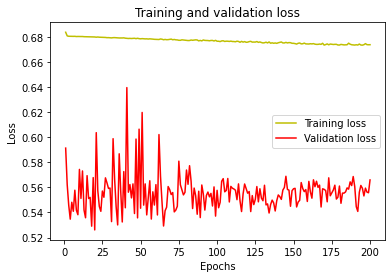

KeyError: 'accuracy'

In [19]:
# plot the accuracy and loss of the training

# loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# IOU 
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.0


In [21]:
# on test dataset
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

ValueError: in user code:

    File "E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "E:\INSTALL\anaconda\envs\seg\lib\site-packages\keras\engine\input_spec.py", line 249, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "U-Net" (type Functional).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 256, 256, 1)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 256, 256, 1), dtype=float32)
      • training=False
      • mask=None
